## This model uses the pre-trained weights for all layers except for the last 2 Conv2D Layers and the Output Layer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#!tar -xf ./drive/MyDrive/school/PetImages.tar -C ./drive/MyDrive/school/

In [ ]:
model = keras.models.load_model('./drive/MyDrive/school/stanford_dogs_model.keras')

In [ ]:
model.summary()
print(len(model.layers))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 180, 180, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 90, 90, 128)  3584        ['rescaling_3[0][0]']            
                                                                                                  
 batch_normalization_24 (BatchN  (None, 90, 90, 128)  512        ['conv2d_12[0][0]']        

In [ ]:
print(model.layers[21].name)
print(model.layers[30].name)

conv2d_14
conv2d_15


In [ ]:
for count, layer in enumerate(model.layers):
  print(count, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7fd0ec62c160>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd0693e4820>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fd0693e40a0>
3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd0693ddee0>
4 <keras.layers.core.activation.Activation object at 0x7fd0693b3820>
5 <keras.layers.core.activation.Activation object at 0x7fd083d1dac0>
6 <keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7fd0693dd9d0>
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd0ec625a00>
8 <keras.layers.core.activation.Activation object at 0x7fd0ec625400>
9 <keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7fd0ec625460>
10 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd072693b50>
11 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fd071ffc370>
12 <keras.layers.convolutional

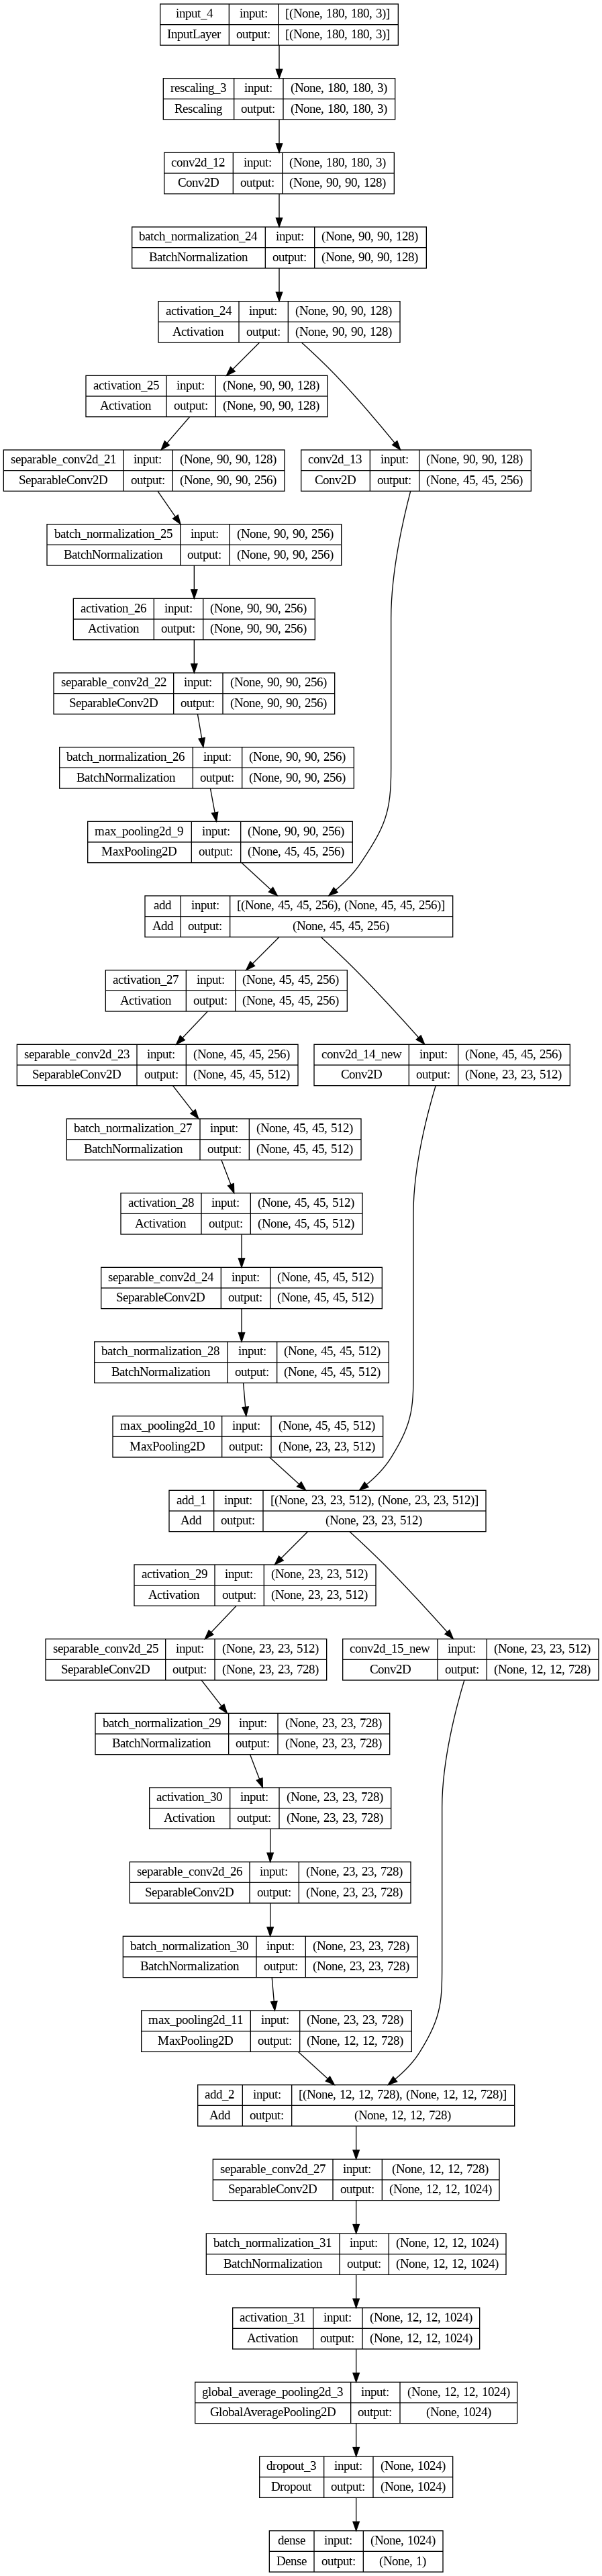

In [ ]:
def make_model():
    inputs = model.input

    # Entry block
    x = model.layers[1](inputs)
    x = model.layers[2](x)
    x = model.layers[3](x)
    x = model.layers[4](x)

    previous_block_activation = x  # Set aside residual

    layer_count = 5
    for size in [256, 512, 728]:
        x = model.layers[layer_count](x)
        layer_count += 1
        x = model.layers[layer_count](x)
        layer_count += 1
        x = model.layers[layer_count](x)
        layer_count += 1

        x = model.layers[layer_count](x)
        layer_count += 1
        x = model.layers[layer_count](x)
        layer_count += 1
        x = model.layers[layer_count](x)
        layer_count += 1

        x = model.layers[layer_count](x)
        layer_count += 1

        # Project residual
        if layer_count == 21:
          residual = layers.Conv2D(size, 1, strides=2, padding="same", name="conv2d_14_new")(
              previous_block_activation
          )
          layer_count += 1
        elif layer_count == 30:
          residual = layers.Conv2D(size, 1, strides=2, padding="same", name="conv2d_15_new")(
              previous_block_activation
          )
          layer_count += 1
        else:
          residual = model.layers[layer_count](previous_block_activation)
          layer_count += 1

        x = layers.add([x, residual])  # Add back residual
        layer_count += 1
        previous_block_activation = x  # Set aside next residual

    x = model.layers[layer_count](x)
    layer_count += 1
    x = model.layers[layer_count](x)
    layer_count += 1
    x = model.layers[layer_count](x)
    layer_count += 1

    x = model.layers[layer_count](x)
    layer_count += 1

    x = model.layers[layer_count](x)
    layer_count += 1

    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

image_size = (180, 180)

model2 = make_model()
keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 180, 180, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 90, 90, 128)  3584        ['rescaling_3[1][0]']            
                                                                                                  
 batch_normalization_24 (BatchN  (None, 90, 90, 128)  512        ['conv2d_12[1][0]']          

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("./drive/MyDrive/school/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "./drive/MyDrive/school/PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 [==============================] - 281s 2s/step - loss: 0.3838 - accuracy: 0.8281 - val_loss: 0.9393 - val_accuracy: 0.6149
Epoch 2/25
147/147 [==============================] - 231s 2s/step - loss: 0.1971 - accuracy: 0.9217 - val_loss: 0.1930 - val_accuracy: 0.9199
Epoch 3/25
147/147 [==============================] - 230s 2s/step - loss: 0.1536 - accuracy: 0.9392 - val_loss: 0.1399 - val_accuracy: 0.9485
Epoch 4/25
147/147 [==============================] - 230s 2s/step - loss: 0.1324 - accuracy: 0.9490 - val_loss: 0.1225 - val_accuracy: 0.9541
Epoch 5/25
147/147 [==============================] - 230s 2s/step - loss: 0.1163 - accuracy: 0.9544 - val_loss: 0.1118 - val_accuracy: 0.9577
Epoch 6/25
147/147 [==============================] - 230s 2s/step - loss: 0.1054 - accuracy: 0.9590 - val_loss: 0.1490 - val_accuracy: 0.9398
Epoch 7/25
147/147 [==============================] - 230s 2s/step - loss: 0.0955 - accuracy: 0.9641 - val_loss: 0.1491 - val_accuracy: 0.9398

In [ ]:
model2.save("experiment4_model.keras")

In [ ]:
from google.colab import files
files.download('./experiment4_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>